In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv")
df.head(5)

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [4]:
categorical = list(df.dtypes[df.dtypes == 'object'].index)
numerical = list(df.dtypes[(df.dtypes == 'int64')  | (df.dtypes == 'float64') ].index)
numerical.remove('converted')

In [5]:
numerical

['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score']

In [6]:
categorical

['lead_source', 'industry', 'employment_status', 'location']

In [7]:
df[categorical]=df[categorical].fillna('NA')
df[numerical]=df[numerical].fillna(0.0)

In [8]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [9]:
y_train=df_train.converted.values
y_val=df_val.converted.values
y_test=df_test.converted.values

In [10]:
del df_train['converted']
del df_val['converted']
del df_test['converted']

In [11]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val= df_val.reset_index(drop=True)

In [12]:
X_train=df_train.values
X_val=df_val.values
X_test=df_test.values

## Q1

In [13]:
for variable in numerical:
    auc = roc_auc_score(y_train, df_train[variable])
    print(variable, round(auc,2))

number_of_courses_viewed 0.76
annual_income 0.53
interaction_count 0.72
lead_score 0.63


## Q2

In [14]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [15]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [16]:
y_pred = model.predict_proba(X_val)[:, 1]

### First method

In [17]:
roc_auc_score(y_val, y_pred)

0.8549315714959888

### Second method

In [18]:
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred)
metrics.auc(fpr, tpr)

0.8549315714959888

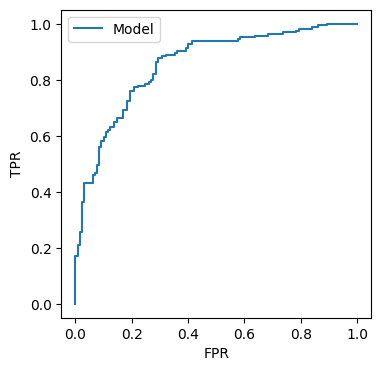

In [19]:
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='Model')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

## Q3

### First method

In [20]:
scores = []

thresholds = np.linspace(0, 1, 101)

actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = np.sum(predict_positive & actual_positive)
    tn = np.sum(predict_negative & actual_negative)
    fp = np.sum(predict_positive & actual_negative)
    fn = np.sum(predict_negative & actual_positive)

    # precision = tp / (tp + fp), recall = tp / (tp + fn)
    precision = np.divide(tp, tp + fp, out=np.zeros(1, dtype=float), where=(tp + fp) != 0).item()
    recall    = np.divide(tp, tp + fn, out=np.zeros(1, dtype=float), where=(tp + fn) != 0).item()

    scores.append((t, tp, fp, fn, tn, precision, recall))


In [21]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'precission', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)

In [22]:
df_scores.head(5)

,threshold,tp,fp,fn,tn,precission,recall
0,0.00,163,130,0,0,0.556314,1.0
1,0.01,163,130,0,0,0.556314,1.0
2,0.02,163,130,0,0,0.556314,1.0
3,0.03,163,130,0,0,0.556314,1.0
4,0.04,163,130,0,0,0.556314,1.0


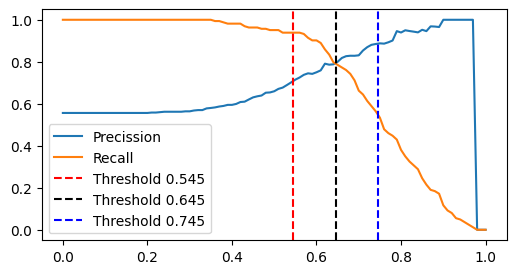

In [23]:
plt.figure(figsize=(6,3))

plt.plot(df_scores.threshold, df_scores['precission'], label='Precission')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')

plt.axvline(x=0.545, color='red', linestyle='--', label='Threshold 0.545')
plt.axvline(x=0.645, color='black', linestyle='--', label='Threshold 0.645')
plt.axvline(x=0.745, color='blue', linestyle='--', label='Threshold 0.745')

plt.legend()
plt.show()

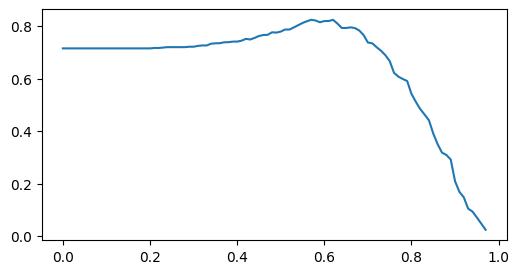

In [24]:
plt.figure(figsize=(6,3))
F1=2*df_scores['precission']*df_scores['recall']/(df_scores['precission']+df_scores['recall'])
plt.plot(df_scores.threshold, F1, label='F1')

### Second method

In [25]:
precission = []
recall = []
f1 = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    y_bin = (y_pred >= t)
    precission.append(precision_score(y_val, y_bin, zero_division=0)) 
    recall.append(recall_score(y_val, y_bin, zero_division=0)) 
    f1.append(f1_score(y_val, y_bin, zero_division=0))

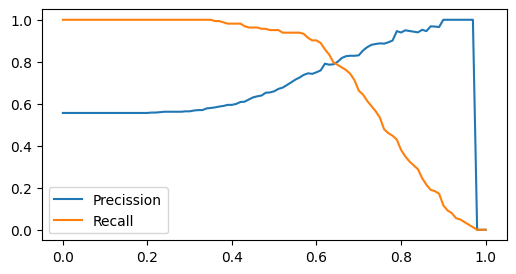

In [35]:
plt.figure(figsize=(6,3))
plt.plot(df_scores.threshold, precission, label='Precission')
plt.plot(df_scores.threshold, recall, label='Recall')
plt.legend()

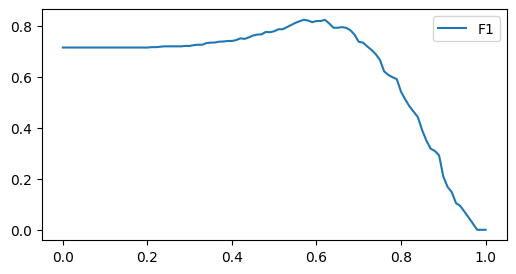

In [27]:
plt.figure(figsize=(6,3))
plt.plot(df_scores.threshold, f1, label='F1')
plt.legend()

## Q5

In [28]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [29]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [30]:
kfold=KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)



In [31]:
scores

[0.7961111111111112,
 0.7797619047619047,
 0.8386788990825688,
 0.8780864197530864,
 0.8442799876657416]

In [32]:
np.mean(scores), np.std(scores)

(np.float64(0.8273836644748824), np.float64(0.03529771110727888))

## Q6

In [33]:
n_splits = 5

for C in [0.000001, 0.001, 1]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.10f +- %.10f' % (C, np.mean(scores), np.std(scores)))

C=1e-06 0.5400335232 +- 0.0301409591
C=0.001 0.8599660152 +- 0.0379539130
C=1 0.8273836645 +- 0.0352977111
